In [1]:
import math
import random
import numpy as np
import networkx as nx
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.stats.weightstats as weightstats
import networkx.generators.random_graphs as random_graphs
%matplotlib inline
# reproducibility
s = 7989
random.seed(s)
np.random.seed(s)

In [2]:
# Listing 1: Python code to estimate π.

N = 100_000_000
pi_est = 4 * sum([1 for _ in range(N) if random.random()**2 + random.random()**2 < 1]) / N

print('Actual:   %.3f' % math.pi)
print('Estimate: %.3f' % pi_est)

Actual:   3.142
Estimate: 3.142


In [3]:
# Listing 2: Python code to simulate A/B tests.

# parameters
conversion_rate = 0.1    # true conversion rate
sample_size = 1_000_000  # number of samples
num_simulations = 10_000 # number of simulations
alpha = 0.05             # significance level

def compute_p_value_one_tailed(conversions_A, conversions_B, N):
    pooled_cr = (conversions_A + conversions_B) / (2 * N)
    s_error = np.sqrt(2 * pooled_cr * (1 - pooled_cr) / N)
    z_score = (conversions_B - conversions_A) / (N * s_error)
    p_value = 1 - stats.norm.cdf(abs(z_score))
    return p_value

# function to perform one A/B test simulation
def simulate_ab_test(conversion_rate, N, lift=0):
    conversions_A = np.random.binomial(N, conversion_rate)
    conversions_B = np.random.binomial(N, conversion_rate * (1 + lift))
    if conversions_B > conversions_A:
        return compute_p_value_one_tailed(conversions_A, conversions_B, sample_size)
    else:
        return 1.0

In [4]:
# Listing 3: A/A test False Positive Rate (FPR) simulation.

# A/A test, ie. A and B are the same
lift = 0.0
p_values = [simulate_ab_test(
    conversion_rate,
    sample_size,
    lift) for _ in range(num_simulations)]
fpr = np.mean(np.array(p_values) < alpha)
print(f"False positive rate: {fpr:.3f}")

False positive rate: 0.051


In [5]:
# Listing 4: A/B test statistical power computation.

lift = 0.01
p_values = [simulate_ab_test(
    conversion_rate,
    sample_size,
    lift) for _ in range(num_simulations)]
sp = np.mean(np.array(p_values) < alpha)
print(f"Statistical power: {sp:.3f}")

Statistical power: 0.762


Simulating 1000 A/B tests, true treatment lift is 2...
N samples  A/B testing, mean lift = 1.99, variance of lift = 0.20
4N samples A/B testing, mean lift = 2.00, variance of lift = 0.05
Raio of lift variance = 0.24 (expected = 0.25)


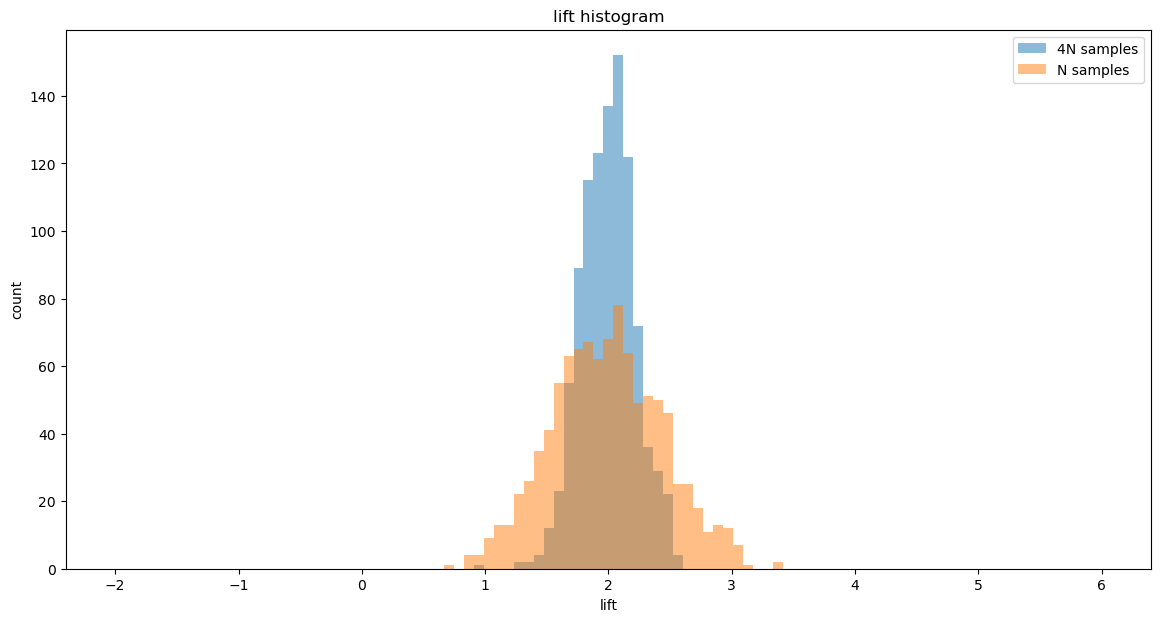

In [6]:
# Figure 1: Monte Carlo simulation illustrating that increasing the
#           sample size reduces the variance of the lift measurement.

def lift(A, B):
    return np.mean(B) - np.mean(A)

def get_AB_samples(mu, sigma, treatment_lift, N):
    A = list(np.random.normal(loc=mu                 , scale=sigma, size=N))
    B = list(np.random.normal(loc=mu + treatment_lift, scale=sigma, size=N))
    return A, B

N = 1_000
N_multiplier = 4
mu = 100
sigma = 10
treatment_lift = 2
num_simulations = 1_000

print('Simulating %s A/B tests, true treatment lift is %d...' % (num_simulations, treatment_lift))

n1_lifts, n4_lifts = [], []
for i in range(num_simulations):
    print('%d/%d' % (i, num_simulations), end='\r')
    A, B = get_AB_samples(mu, sigma, treatment_lift, N)
    n1_lifts.append(lift(A, B))
    A, B = get_AB_samples(mu, sigma, treatment_lift, N_multiplier*N)
    n4_lifts.append(lift(A, B))
    
print('N samples  A/B testing, mean lift = %.2f, variance of lift = %.2f' % (np.mean(n1_lifts), np.cov(n1_lifts)))
print('4N samples A/B testing, mean lift = %.2f, variance of lift = %.2f' % (np.mean(n4_lifts), np.cov(n4_lifts)))
print('Raio of lift variance = %.2f (expected = %.2f)' % (np.cov(n4_lifts)/np.cov(n1_lifts), 1/N_multiplier))

bins = np.linspace(-2, 6, 100)
plt.figure(figsize=(14, 7))
plt.hist(n4_lifts, bins, alpha=0.5, label=f'{N_multiplier}N samples')
plt.hist(n1_lifts, bins, alpha=0.5, label='N samples')
plt.xlabel('lift')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('lift histogram')
plt.show()

Simulating 1000 A/B tests, true treatment lift is 2...
Even split   A/B testing, mean lift = 1.99, variance of lift = 0.09
Uneven split A/B testing, mean lift = 1.99, variance of lift = 0.27
Raio of lift variance = 0.36 (expected = 0.36)


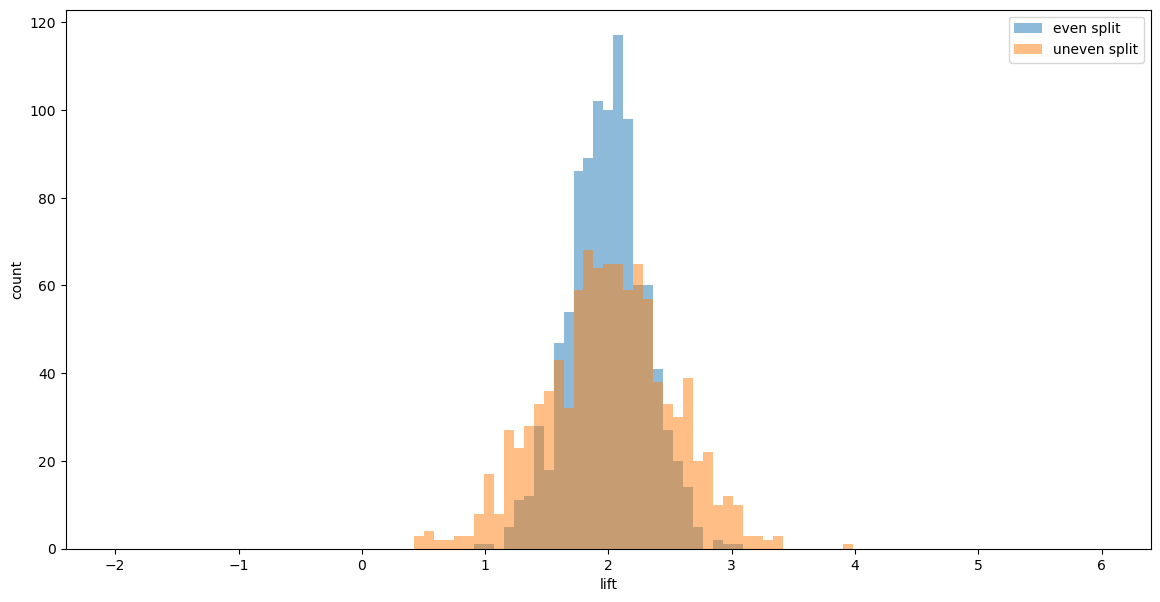

In [7]:
# Figure 2: Monte Carlo simulation illustrating that moving towards a
#           more even split reduces the variance of the lift measurement.

def get_AB_samples(mu, sigma, treatment_lift, N_A, N_B):
    A = list(np.random.normal(loc=mu                 , scale=sigma, size=N_A))
    B = list(np.random.normal(loc=mu + treatment_lift, scale=sigma, size=N_B))
    return A, B

def expected_ratio(p, q):
    top = 1/p + 1/(1-p)
    bot = 1/q + 1/(1-q)
    return top/bot

N = 4_000
mu = 100
sigma = 10
treatment_lift = 2
even_ratio = 0.5
uneven_ratio = 0.9
num_simulations = 1_000

print('Simulating %s A/B tests, true treatment lift is %d...' % (num_simulations, treatment_lift))

even_lifts, uneven_lifts = [], []
for i in range(num_simulations):
    print('%d/%d' % (i, num_simulations), end='\r')
    A, B = get_AB_samples(mu, sigma, treatment_lift, int(N*even_ratio), int(N*(1-even_ratio)))
    even_lifts.append(lift(A, B))
    A, B = get_AB_samples(mu, sigma, treatment_lift, int(N*uneven_ratio), int(N*(1-uneven_ratio)))
    uneven_lifts.append(lift(A, B))
    
print('Even split   A/B testing, mean lift = %.2f, variance of lift = %.2f' % (np.mean(even_lifts),   np.cov(even_lifts)))
print('Uneven split A/B testing, mean lift = %.2f, variance of lift = %.2f' % (np.mean(uneven_lifts), np.cov(uneven_lifts)))
print('Raio of lift variance = %.2f (expected = %.2f)' % ((np.cov(even_lifts)/np.cov(uneven_lifts)), expected_ratio(even_ratio, uneven_ratio)))

bins = np.linspace(-2, 6, 100)
plt.figure(figsize=(14, 7))
plt.hist(even_lifts,   bins, alpha=0.5, label='even split')
plt.hist(uneven_lifts, bins, alpha=0.5, label='uneven split')
plt.xlabel('lift')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.show()

Simulating 1000 A/B tests, true treatment lift is 2...
Traditional    A/B testing, mean lift = 2.02, variance of lift = 5.86
CUPED adjusted A/B testing, mean lift = 1.98, variance of lift = 0.75
CUPED lift variance / tradititional lift variance = 0.13 (expected = 0.14)


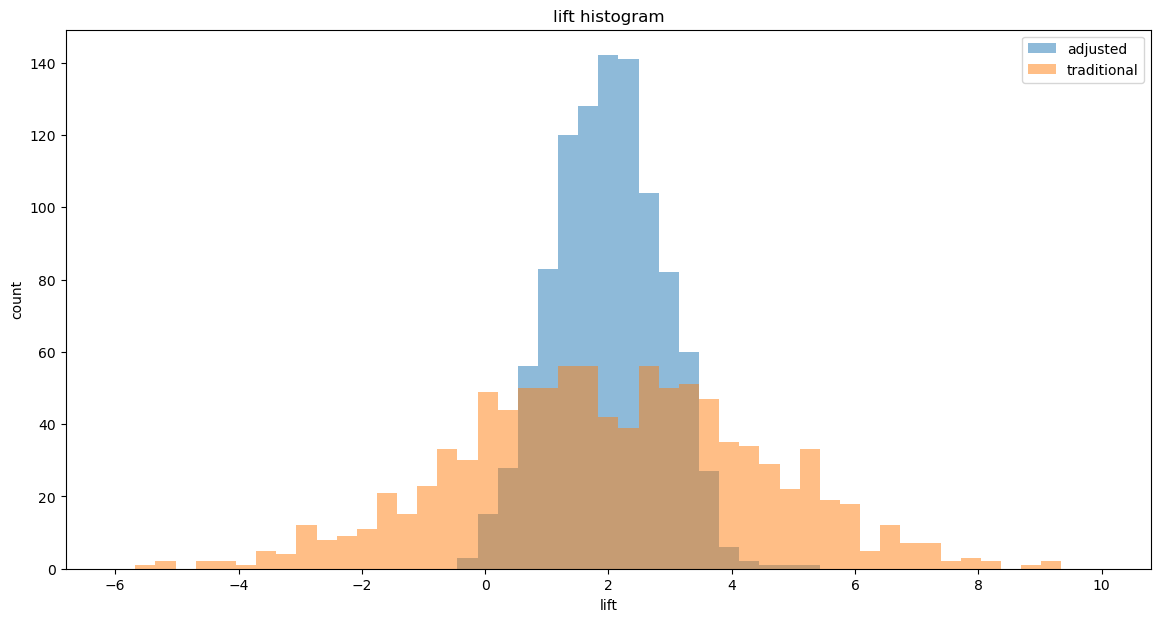

In [8]:
# Figure 3: Monte Carlo simulation illustrating that using CUPED to take into
#           account historic data reduces the variance of the lift measurement.

def get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, N):
    A_before = list(np.random.normal(loc=before_mean, scale=before_sigma, size=N))
    B_before = list(np.random.normal(loc=before_mean, scale=before_sigma, size=N))
    A_after  = [x + np.random.normal(loc=0, scale=eps_sigma) for x in A_before]
    B_after  = [x + np.random.normal(loc=0, scale=eps_sigma) + treatment_lift for x in B_before]
    return A_before, B_before, A_after, B_after

def get_cuped_adjusted(A_before, B_before, A_after, B_after):
    cv = np.cov([A_after + B_after, A_before + B_before])
    theta = cv[0, 1] / cv[1, 1]
    mean_before = np.mean(A_before + B_before)
    A_after_adjusted = [after - (before - mean_before) * theta for after, before in zip(A_after, A_before)]
    B_after_adjusted = [after - (before - mean_before) * theta for after, before in zip(B_after, B_before)]
    return A_after_adjusted, B_after_adjusted

def get_cuped_adjusted_lr(A_before, B_before, A_after, B_after):
    lr = stats.linregress(A_before + B_before, A_after + B_after)
    mean_after = mean(A_after + B_after)
    A_after_adjusted = [mean_after + after - (lr.intercept + before * lr.slope) for after, before in zip(A_after, A_before)]
    B_after_adjusted = [mean_after + after - (lr.intercept + before * lr.slope) for after, before in zip(B_after, B_before)]
    return A_after_adjusted, B_after_adjusted

def expected_lift_ratio(A_before, B_before, A_after, B_after):
    cv = np.cov([A_after + B_after, A_before + B_before])
    corr = cv[0, 1] / (math.sqrt(cv[0, 0]) * math.sqrt(cv[1, 1]))
    return 1 - corr**2

def lift(A, B):
    return np.mean(B) - np.mean(A)

N = 1000
before_mean = 100 
before_sigma = 50
eps_sigma = 20
treatment_lift = 2
num_simulations = 1000

print('Simulating %s A/B tests, true treatment lift is %d...' % (num_simulations, treatment_lift))

traditional_lifts, adjusted_lifts = [], []
for i in range(num_simulations):
    print('%d/%d' % (i, num_simulations), end='\r')
    A_before, B_before, A_after, B_after = get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, N)
    A_after_adjusted, B_after_adjusted = get_cuped_adjusted(A_before, B_before, A_after, B_after)
    traditional_lifts.append(lift(A_after, B_after))
    adjusted_lifts.append(lift(A_after_adjusted, B_after_adjusted))
    
print('Traditional    A/B testing, mean lift = %.2f, variance of lift = %.2f' % (np.mean(traditional_lifts), np.cov(traditional_lifts)))
print('CUPED adjusted A/B testing, mean lift = %.2f, variance of lift = %.2f' % (np.mean(adjusted_lifts),    np.cov(adjusted_lifts)))

large_N = 1000*1000
A_before, B_before, A_after, B_after = get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, large_N)
elr = expected_lift_ratio(A_before, B_before, A_after, B_after)
print('CUPED lift variance / tradititional lift variance = %.2f (expected = %.2f)' % (np.cov(adjusted_lifts)/np.cov(traditional_lifts), elr))

bins = np.linspace(-6, 10, 50)
plt.figure(figsize=(14, 7))
plt.hist(adjusted_lifts,    bins, alpha=0.5, label='adjusted')
plt.hist(traditional_lifts, bins, alpha=0.5, label='traditional')
plt.xlabel('lift')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('lift histogram')
plt.show()

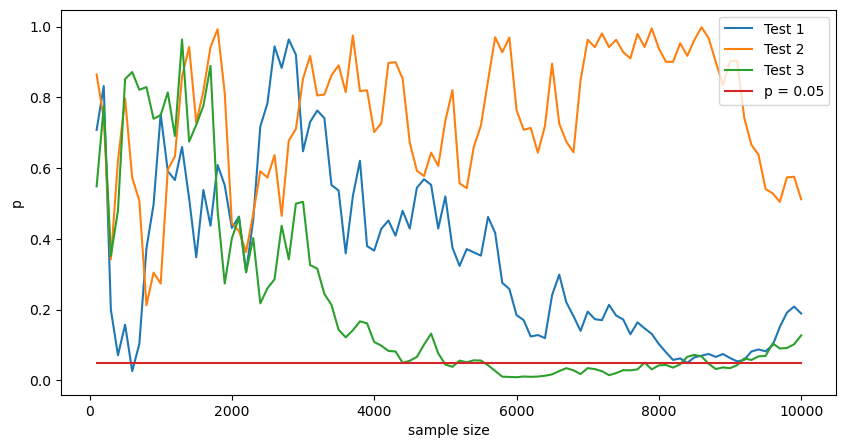

In [9]:
# Figure 4: P-values for three A/A test simulations runs, evaluated every 100
#           samples, 100 times for a total of $ N=10\,000$ samples.

np.random.seed(7531) # reproducibility

def choice(ps):
    return np.random.choice(len(ps), p=ps)

def simulate_abtest(funnels, N):
    traffic_split = [x[1] for x in funnels]
    observations = np.zeros([len(funnels), len(funnels[0][0])])
    for _ in range(N):
        which_funnel = choice(traffic_split)
        funnel_outcome = choice(funnels[which_funnel][0])
        observations[which_funnel][funnel_outcome] += 1
    return observations
    
def abtest_episode(funnels, N, prior_observations=None):
    observations = simulate_abtest(funnels, N)
    if prior_observations is not None:
        observations += prior_observations
    p = stats.chi2_contingency(observations, correction=False)[1]
    return observations, p

def repeated_significances(funnels, episodes):
    results = []
    observations = None
    for i in range(len(episodes)):
        observations, p = abtest_episode(funnels, episodes[i], observations)
        N = np.sum(observations)
        results.append((N, p))
    return results

Ns = [100] * 100
T = 2000
funnels = [
    [[0.50, 0.50], 0.5], # the first vector is the actual outcomes,
    [[0.50, 0.50], 0.5], # the second is the traffic split
]
results1 = repeated_significances(funnels, Ns)
results2 = repeated_significances(funnels, Ns)
results3 = repeated_significances(funnels, Ns)

plt.figure(figsize=(10,5))
plt.xlabel('sample size')
plt.ylabel('p')
plt.plot([x[0] for x in results1], [x[1] for x in results1])
plt.plot([x[0] for x in results2], [x[1] for x in results2])
plt.plot([x[0] for x in results3], [x[1] for x in results3])
plt.plot([x[0] for x in results3], [0.05 for _ in results3])
plt.legend(['Test 1', 'Test 2', 'Test 3', 'p = 0.05'], loc='upper right')
plt.show()

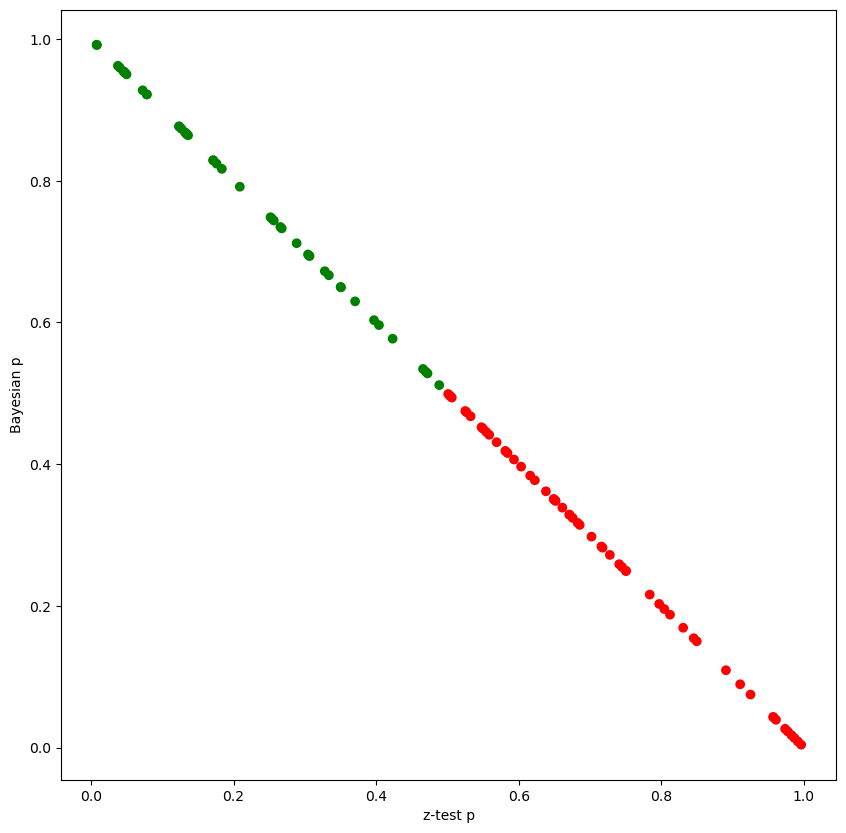

In [10]:
# Figure 5: Monte Carlo simulations show that in many scenarios, the frequentists p-value $p_f$ and the
#           bayesian probability $p_b$ are complemantary and the approximation  $ p_f + p_b \approx 1 $ holds.

def bayesian_prob_mc(observations, num_samples = 1000*1000):
    beta_A = stats.beta(observations[0][1], observations[0][0])
    beta_B = stats.beta(observations[1][1], observations[1][0])
    samples_A = beta_A.rvs(size=num_samples)
    samples_B = beta_B.rvs(size=num_samples)
    hits = sum([a <= b for a, b in zip(samples_A, samples_B)])
    return hits/num_samples

def bayesian_prob(observations):
    beta_A = stats.beta(observations[0][1], observations[0][0])
    beta_B = stats.beta(observations[1][1], observations[1][0])
    return calc_prob_between(beta_B, beta_A)

def h(a, b, c, d):
    num = math.lgamma(a + c) + math.lgamma(b + d) + math.lgamma(a + b) + math.lgamma(c + d)
    den = math.lgamma(a) + math.lgamma(b) + math.lgamma(c) + math.lgamma(d) + math.lgamma(a + b + c + d)
    return np.exp(num - den)

def g0(a, b, c):    
    return np.exp(math.lgamma(a + b) + math.lgamma(a + c) - (math.lgamma(a + b + c) + math.lgamma(a)))

def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

def take(li, k):
    return [i[k] for i in li]

def conversion(funnel):
    return funnel[1] / (funnel[0] + funnel[1])

def to_individual_observations(observations):
    return (int(observations[0][0])*[0] + int(observations[0][1])*[1], int(observations[1][0])*[0] + int(observations[1][1])*[1])

def z_test(observations):
    iobs = to_individual_observations(observations)
    return weightstats.CompareMeans.from_data(iobs[1], iobs[0]).ztest_ind(alternative='larger', usevar='unequal')[1]

def run_simulations(funnels, N, num_simulations):
    results = []
    for _ in range(num_simulations):
        observations = simulate_abtest(funnels, N)
        pf = z_test(observations)
        pb = bayesian_prob(observations)
        conv_A = conversion(observations[0])
        conv_B = conversion(observations[1])
        results.append((conv_B - conv_A, pf, pb, 'green' if conv_A <= conv_B else 'red'))
    return results

funnels = [
    [[0.50, 0.50], 0.5], # the first vector is the actual outcomes,
    [[0.50, 0.50], 0.5], # the second is the traffic split
]
N = 1000
num_simulations = 100

results = run_simulations(funnels, N, num_simulations)

plt.figure(figsize=(10, 10))
plt.xlabel('z-test p')
plt.ylabel('Bayesian p')
plt.scatter(x=take(results, 1), y=take(results, 2), c=take(results, 3))
plt.show()

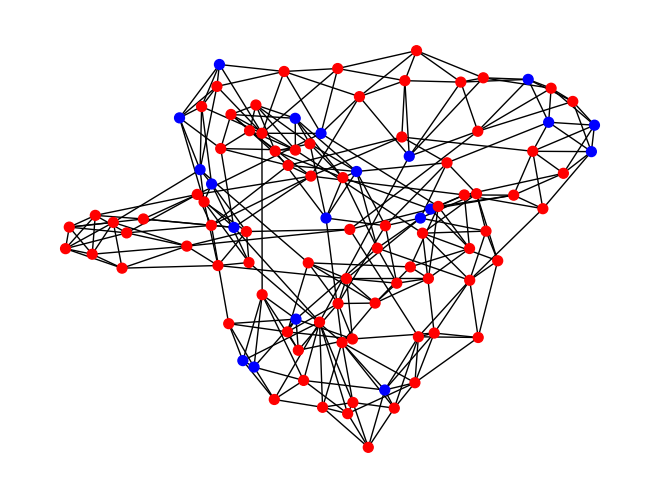

In [11]:
# Figure 6: Watts-Strogatz graph with $(n=100, k=6, p=0.1)$,
#           with $N=20$ random treatment nodes colored blue.

s = 342423
random.seed(s)
np.random.seed(s)
g = random_graphs.connected_watts_strogatz_graph(n=100, k=6, p=0.1)
N = 20
treatment = set(random.sample(list(g.nodes), N))
color_map = []
for node in g:
    if node in treatment:
        color_map.append('blue')
    else: 
        color_map.append('red')      
pos = nx.spring_layout(g)
nx.draw(g, pos, node_color=color_map, node_size=50)
plt.show()